In [3]:
import torch
import torch.utils.data
import torch.nn as nn
import csv
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.gridspec

In [4]:
# function to create a grayscale copy of an image for training
def make_gray(im):
    grayim = []
    for i in range(len(im)):
        grayim.append([])
        for j in range(len(im[i])):
            average = int(np.average(im[i][j][0:3]))
            if (len(im[i][j]) == 3):
                grayim[-1].append([average,average, average])
            else:
                grayim[-1].append([average,average, average, 255])

    grayim = np.array(grayim)

    return grayim

In [5]:
# create the dataset for training

class_names = np.array(['House', 'Tree'])

ADD_GRAY_IMAGES = True

# Loads the labeled houses and trees
ds = []
labels = []
with open('Dataset.csv', newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:

        
        # Find the labeled portion of the image
        x1 = int(row['bbox_x'])
        x2 = int(row['bbox_x']) + int(row['bbox_width'])
        y1 = int(row['bbox_y'])
        y2 = int(row['bbox_y']) + int(row['bbox_height'])
        # trim image to find the correct part for training
        im = np.array(Image.open('Images/' + row['image_name']))[y1:y2, x1:x2, 0:3]
        # resize the image so that it is proper size for our model
        im = np.array(Image.fromarray(im).resize((32,32)))

        # labels need to be integers
        labels.append(np.where(class_names == row['label_name'])[0][0])
        # append image
        ds.append(im)

        if (ADD_GRAY_IMAGES):
            # add a grayscale of the same image to the dataset
            labels.append(np.where(class_names == row['label_name'])[0][0])
            ds.append(make_gray(im))


# Spliting training and testing data
trainLabels = torch.from_numpy(np.array(labels[:int(.9*len(labels))])).type(torch.LongTensor)
trainImages = torch.from_numpy((np.array(ds[:int(.9*len(ds))]))).type(torch.float32)
testingLabels = torch.from_numpy((np.array(labels[int(.9*len(labels)):]))).type(torch.LongTensor)
testingImages = torch.from_numpy(np.array(ds[int(.9*len(ds)):])).type(torch.float32)

trainImages = torch.reshape(trainImages, (len(trainImages), 3, 32, 32))
testingImages = torch.reshape(testingImages, (len(testingImages), 3, 32, 32))

# build the datasets
trainSet = torch.utils.data.TensorDataset(trainImages, trainLabels)
trainLoader = torch.utils.data.DataLoader(dataset=trainSet,
                                          batch_size=10,
                                          shuffle=True)

testSet = torch.utils.data.TensorDataset(testingImages, testingLabels)
testLoader = torch.utils.data.DataLoader(dataset=testSet,
                                         batch_size=10,
                                         shuffle=True)
print(len(labels))

656


In [6]:
# The class of the model

class ConvNeuralNet(nn.Module):
	# Construct the layers with a specified number of neurons
    def __init__(self):
        super(ConvNeuralNet, self).__init__()
        self.conv_layer1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.conv_layer2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
        self.max_pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        
        self.conv_layer3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.conv_layer4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)
        self.max_pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        
        self.fc1 = nn.Linear(1600, 128)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, len(class_names))
    
    # feed forward
    def forward(self, x):
        out = self.conv_layer1(x)
        out = self.conv_layer2(out)
        out = self.max_pool1(out)
        
        out = self.conv_layer3(out)
        out = self.conv_layer4(out)
        out = self.max_pool2(out)
                
        out = out.reshape(out.size(0), -1)
        
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        return out


In [7]:
# train the model

model = ConvNeuralNet()

LR = 0.0003
num_epochs = 10


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)    

total_step = len(trainLoader)

accuracy = []
val_accuracy = []
# train the model over the training data set
model.train()
for epoch in range(num_epochs):
    for i, (img, lab) in enumerate(trainLoader):  
        outputs = model(img)
        loss = criterion(outputs, lab)
        
        # update weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print("Epoch:", str(epoch + 1) + "/" + str(num_epochs), "complete")
    # Evaluate the model to get accuracy and val_accuracy
    model.eval()
    with torch.no_grad():
        outputs = model(trainImages)
        _, predicted = torch.max(outputs.data, 1)
        accuracy.append((predicted == trainLabels).sum().item() / len(trainImages))

        outputs = model(testingImages)
        _, predicted = torch.max(outputs.data, 1)
        val_accuracy.append((predicted == testingLabels).sum().item() / len(testingImages))

    model.train()

Epoch: 1/10 complete
Epoch: 2/10 complete
Epoch: 3/10 complete
Epoch: 4/10 complete
Epoch: 5/10 complete
Epoch: 6/10 complete
Epoch: 7/10 complete
Epoch: 8/10 complete
Epoch: 9/10 complete
Epoch: 10/10 complete


[0.6515151515151515, 0.696969696969697, 0.7121212121212122, 0.8333333333333334, 0.7424242424242424, 0.7575757575757576, 0.7272727272727273, 0.7727272727272727, 0.7272727272727273, 0.7575757575757576]


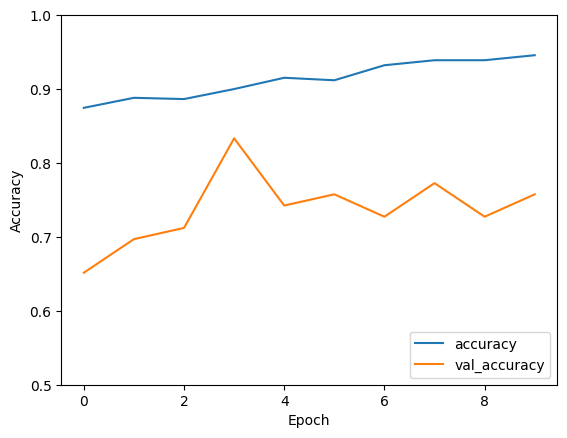

In [9]:
# Plot the model results
print(val_accuracy)
plt.plot(accuracy, label='accuracy')
plt.plot(val_accuracy, label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.savefig("torchAccuracyGraph.png")
plt.show()

In [121]:
# uses a model to perform object detection on the specified image (file location of image)
def detect(model, location):
  gridification = 4
  pixels = int(256 / gridification)

  imArray = []

  im = np.array(Image.open(location))
  imArray.append(im)

  plt.figure(figsize=(10, 10))
  gs = matplotlib.gridspec.GridSpec(gridification, gridification, width_ratios=[1, 1, 1, 1],
          wspace=0.0, hspace=0.0, top=1.0, bottom=0.0, left=0.0, right=1.0)
  imNum = 1
  result = []
  houses = 0
  trees = 0
  for i in range(len(imArray)):
    for x in range(gridification):
      result.append([])
      for y in range(gridification):
        chunk = imArray[i][pixels*x:pixels*(x+1)-1, pixels*y:pixels*(y+1)-1, 0:3]
        ax = plt.subplot(gs[x, y])
        ax.set_aspect("auto")
        imNum = imNum + 1
        plt.imshow(chunk)
        plt.axis("off")
        chunk = np.array(Image.fromarray(chunk).resize((32,32)))
        chunko = torch.from_numpy(chunk).type(torch.float32)
        chunko = torch.reshape(chunko, (1, 3, 32, 32))
        predictions = model(chunko)
        score = predictions.softmax(dim=1)

        val, preds = torch.max(score, 1)
        if (100 * val.item() > 80):
          result[-1].append([class_names[preds.item()], val.item() * 100])
          if class_names[preds.item()] == "House":
            ax.add_patch(plt.Rectangle((0,0), pixels-1.5, pixels-1.5, lw=3, fill=False, color="red"))
            houses = houses + 1
          elif class_names[preds.item()] == "Tree":
            ax.add_patch(plt.Rectangle((0,0), pixels-1.5, pixels-1.5, lw=3, fill=False, color="green"))
            trees = trees + 1
          
        else:
          result[-1].append(['nothing', val.item() * 100])

  plt.subplots_adjust(wspace=0,hspace=0)
  plt.savefig("torchObjectDetection.png")
  print(result)
  print("houses:", houses)
  print("trees:", trees)

[[['Tree', 99.8042345046997], ['nothing', 59.48647856712341], ['nothing', 62.74629831314087], ['nothing', 57.725077867507935]], [['Tree', 99.81040954589844], ['House', 98.17143678665161], ['House', 88.90236020088196], ['nothing', 65.20262956619263]], [['nothing', 66.78403615951538], ['Tree', 85.7681930065155], ['Tree', 98.82148504257202], ['nothing', 73.26244115829468]], [['nothing', 51.90512537956238], ['Tree', 96.81525230407715], ['Tree', 89.35215473175049], ['Tree', 85.1587176322937]]]
houses: 2
trees: 7


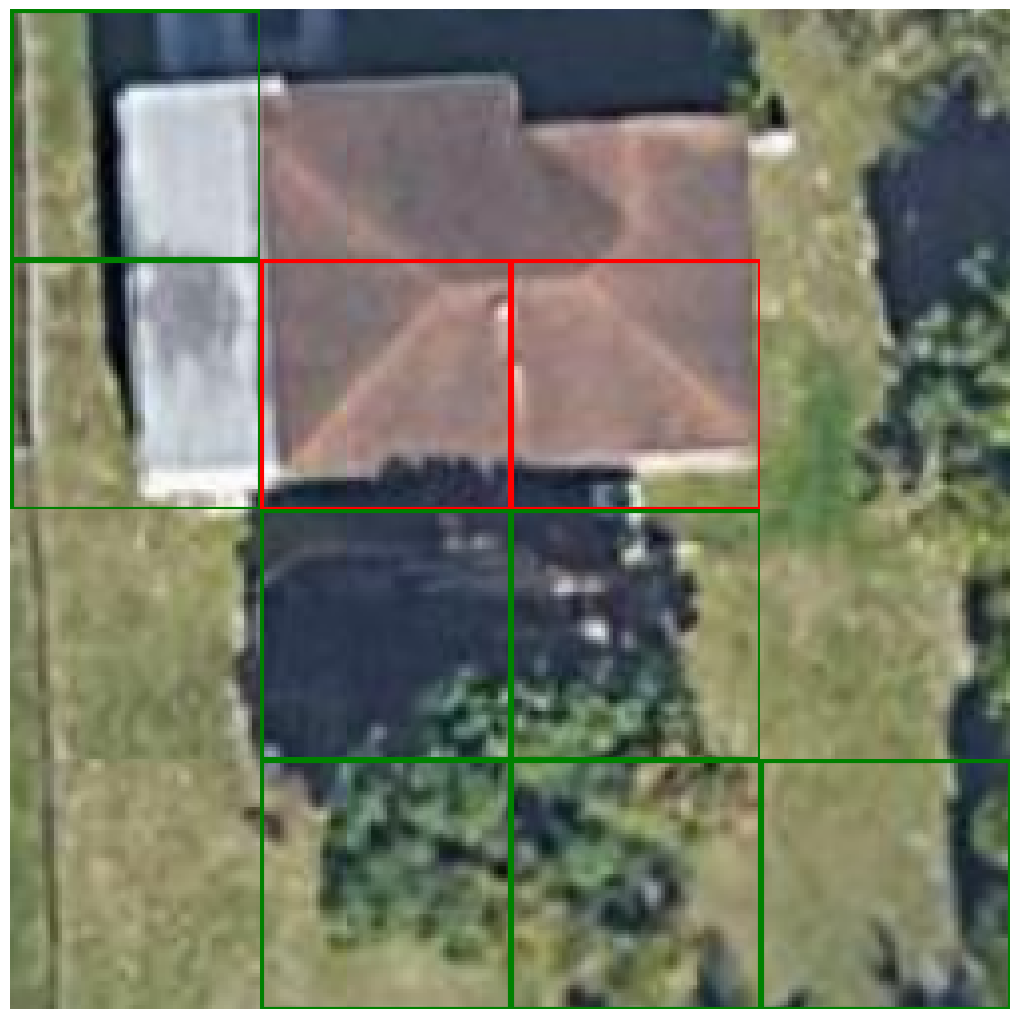

In [122]:

# Object detection
detect(model, 'Images/2023-03-13_17-53-07.png')

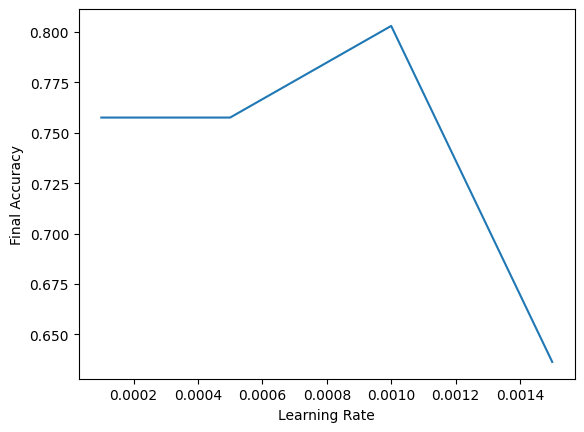

In [10]:
# evaluation of learning rate
learning_rates = [.0001, .0005, .001, .0015]

accuracy_graph = []
num_epochs = 10

for lr in learning_rates:
    model = ConvNeuralNet()

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)    

    total_step = len(trainLoader)

    accuracy = []
    val_accuracy = []
    # train the model over the training data set
    model.train()
    for epoch in range(num_epochs):
        for i, (img, lab) in enumerate(trainLoader):  
            outputs = model(img)
            loss = criterion(outputs, lab)
            
            # update weights
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    model.eval()
    with torch.no_grad():
        outputs = model(testingImages)
        _, predicted = torch.max(outputs.data, 1)
        accuracy_graph.append((predicted == testingLabels).sum().item() / len(testingImages))


plt.plot(learning_rates, accuracy_graph, label='accuracy')
plt.xlabel('Learning Rate')
plt.ylabel('Final Accuracy')
plt.savefig("torchLearningRateGraph")
plt.show()